In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e15/sample_submission.csv
/kaggle/input/playground-series-s3e15/data.csv


In [2]:
!pip install scikit-learn==1.2
!pip install pygam==0.8.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 31.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00a 0:00:01


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [14]:
# Set seaborn theme and color palette
sns.set_theme(style='white', palette='viridis')


In [15]:
# Set pandas display options
pd.set_option('display.max_rows', 100)


## 1. Data preprocessing

In [6]:
data = pd.read_csv(r'../input/playground-series-s3e15/data.csv')


In [17]:
data.columns

Index(['author', 'geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]',
       'x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]',
       'chf_exp [MW/m2]'],
      dtype='object')

In [7]:
# Drop 'id' column 
data.drop('id', axis=1, inplace=True)


In [8]:
# Split features into categorical and numerical
categorical_features = data.columns[:2]
numerical_features = data.columns[2:]

- This section reads the data from the CSV files and drops the 'id' column from both data and orig_data dataframes.
- It also splits the features into categorical and numerical features for further processing.

In [9]:
# Define a simple categorical imputer
class SimpleCategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        x_copy = x.copy()
        x_copy['author'] = x_copy['author'].fillna('Thompson')
        x_copy['geometry'] = x_copy['geometry'].fillna('tube')
        return x_copy


In [10]:
# Create a categorical preprocessor pipeline
categorical_preprocessor = Pipeline([
    ('categorical_imputer', SimpleCategoricalImputer()),
    ('onehot', OneHotEncoder(cols=categorical_features)),
])

In [11]:
# Preprocess the data 
preprocessed_data = categorical_preprocessor.fit_transform(data)


In [12]:
# Apply regex to column names to handle special characters
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
preprocessed_data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in preprocessed_data.columns.values]


- This section defines a custom categorical imputer using SimpleCategoricalImputer class, which fills missing values in categorical columns with specific values.
- It creates a categorical preprocessor pipeline using OneHotEncoder to one-hot encode the categorical features.
- The preprocessed data and original data are transformed using the categorical preprocessor pipeline.
- Regular expressions are applied to column names to handle any special characters in the column names.

In [19]:
print(preprocessed_data.columns)


Index(['author_1', 'author_2', 'author_3', 'author_4', 'author_5', 'author_6',
       'author_7', 'author_8', 'author_9', 'author_10', 'geometry_1',
       'geometry_2', 'geometry_3', 'pressure _MPa_', 'mass_flux _kg/m2-s_',
       'x_e_out _-_', 'D_e _mm_', 'D_h _mm_', 'length _mm_',
       'chf_exp _MW/m2_'],
      dtype='object')


## 2. Feature Engineering

In [24]:
# Creating a new feature by combining existing features
preprocessed_data['pressure_mass_flux'] = preprocessed_data['pressure _MPa_'] * preprocessed_data['mass_flux _kg/m2-s_']

# Log transformation of a numerical feature
preprocessed_data['log_chf_exp'] = np.log1p(preprocessed_data['chf_exp _MW/m2_'])

# Feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
preprocessed_data[['pressure_mass_flux', 'log_chf_exp']] = scaler.fit_transform(preprocessed_data[['pressure_mass_flux', 'log_chf_exp']])


In this step, We performed the following steps - 

1. Creating a new feature by combining existing features:
   - The `pressure_mass_flux` feature is created by multiplying the values from the `pressure _MPa_` column and the `mass_flux _kg/m2-s_` column. This step aims to capture any potential interaction or relationship between the pressure and mass flux variables.

2. Log transformation of a numerical feature:
   - The `log_chf_exp` feature is obtained by applying the natural logarithm transformation (using `np.log1p`) to the values in the `chf_exp _MW/m2_` column. Log transformations are commonly used to handle skewed distributions and can help in normalizing the data and improving the model's performance.


3. Feature scaling:
   - The `pressure_mass_flux` and `log_chf_exp` features are scaled using Min-Max scaling. This scaling technique transforms the values of each feature to a range between 0 and 1, preserving the relative differences between the values. Scaling the features can be beneficial for certain machine learning algorithms that are sensitive to the scale of the input features.


## 3. Exploratory Data Analysis

In [26]:
# columns for EDA
eda_columns = ['author_1', 'author_2', 'author_3', 'author_4', 'author_5', 'author_6',
               'author_7', 'author_8', 'author_9', 'author_10', 'geometry_1',
               'geometry_2', 'geometry_3', 'pressure _MPa_', 'mass_flux _kg/m2-s_',
               'x_e_out _-_', 'D_e _mm_', 'D_h _mm_', 'length _mm_', 'chf_exp _MW/m2_',
               'pressure_mass_flux', 'log_chf_exp']


`eda_columns`: This is a list of column names that are used for EDA. It includes both numerical and categorical features, as well as the target variable and engineered features.

In [28]:
# numerical features
numerical_columns = ['pressure _MPa_', 'mass_flux _kg/m2-s_', 'length _mm_', 'chf_exp _MW/m2_',
                     'pressure_mass_flux', 'log_chf_exp']

`numerical_columns`: This is a list of column names that represent numerical features.

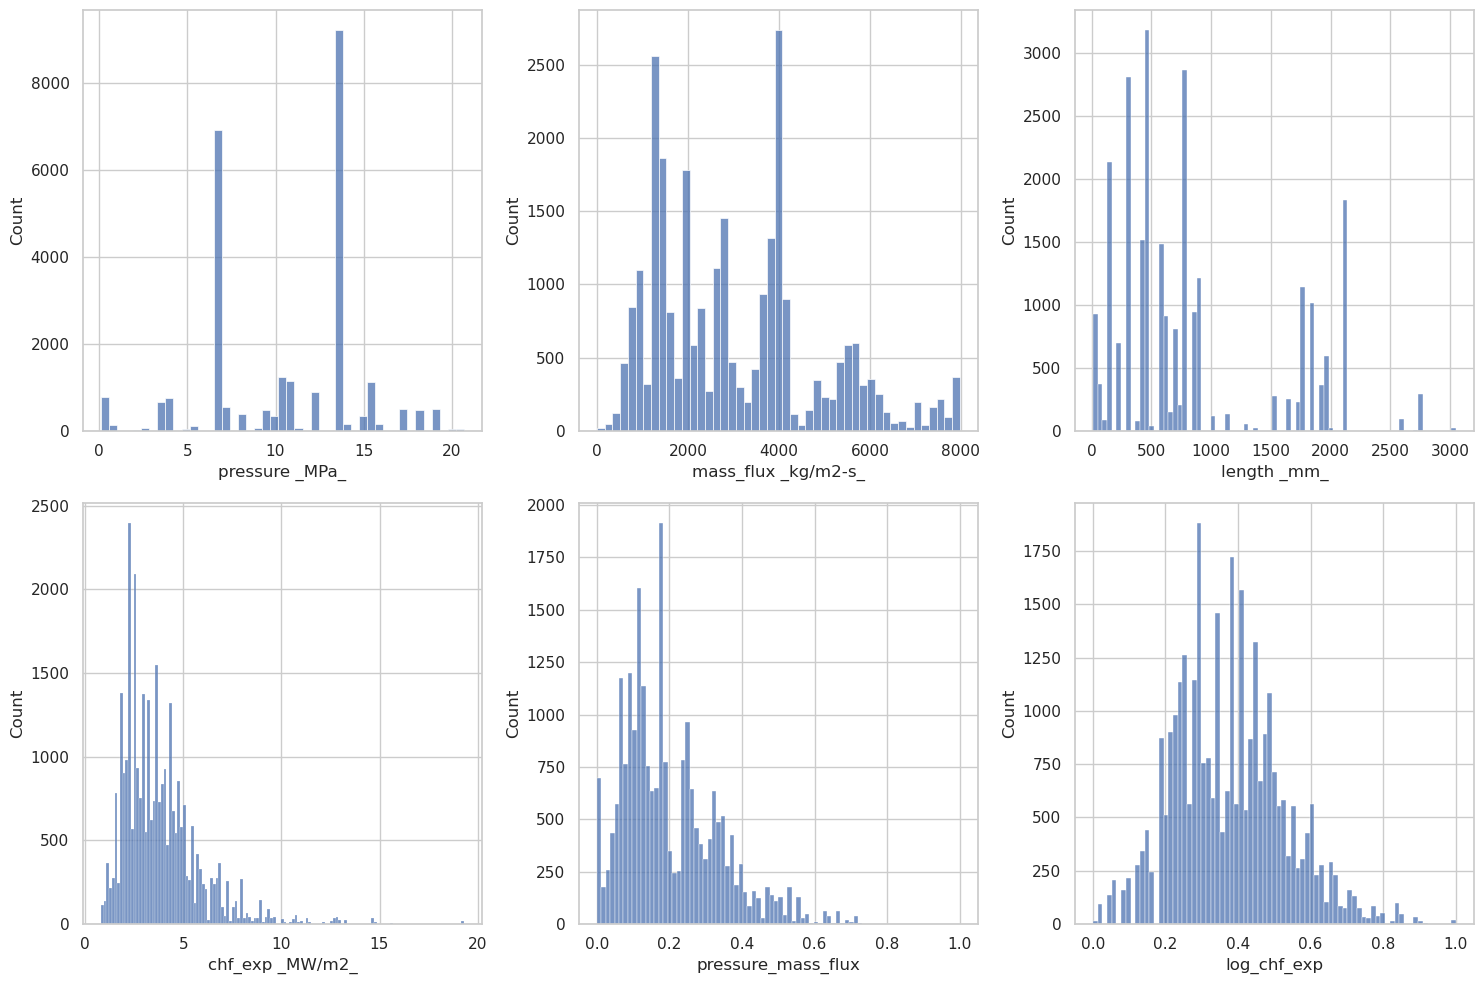

In [29]:
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    ax = axes[i // 3, i % 3]
    sns.histplot(preprocessed_data[col], ax=ax)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

`sns.histplot`: This code snippet creates a histogram for each numerical feature using seaborn's histplot function. It visualizes the distribution of each feature.

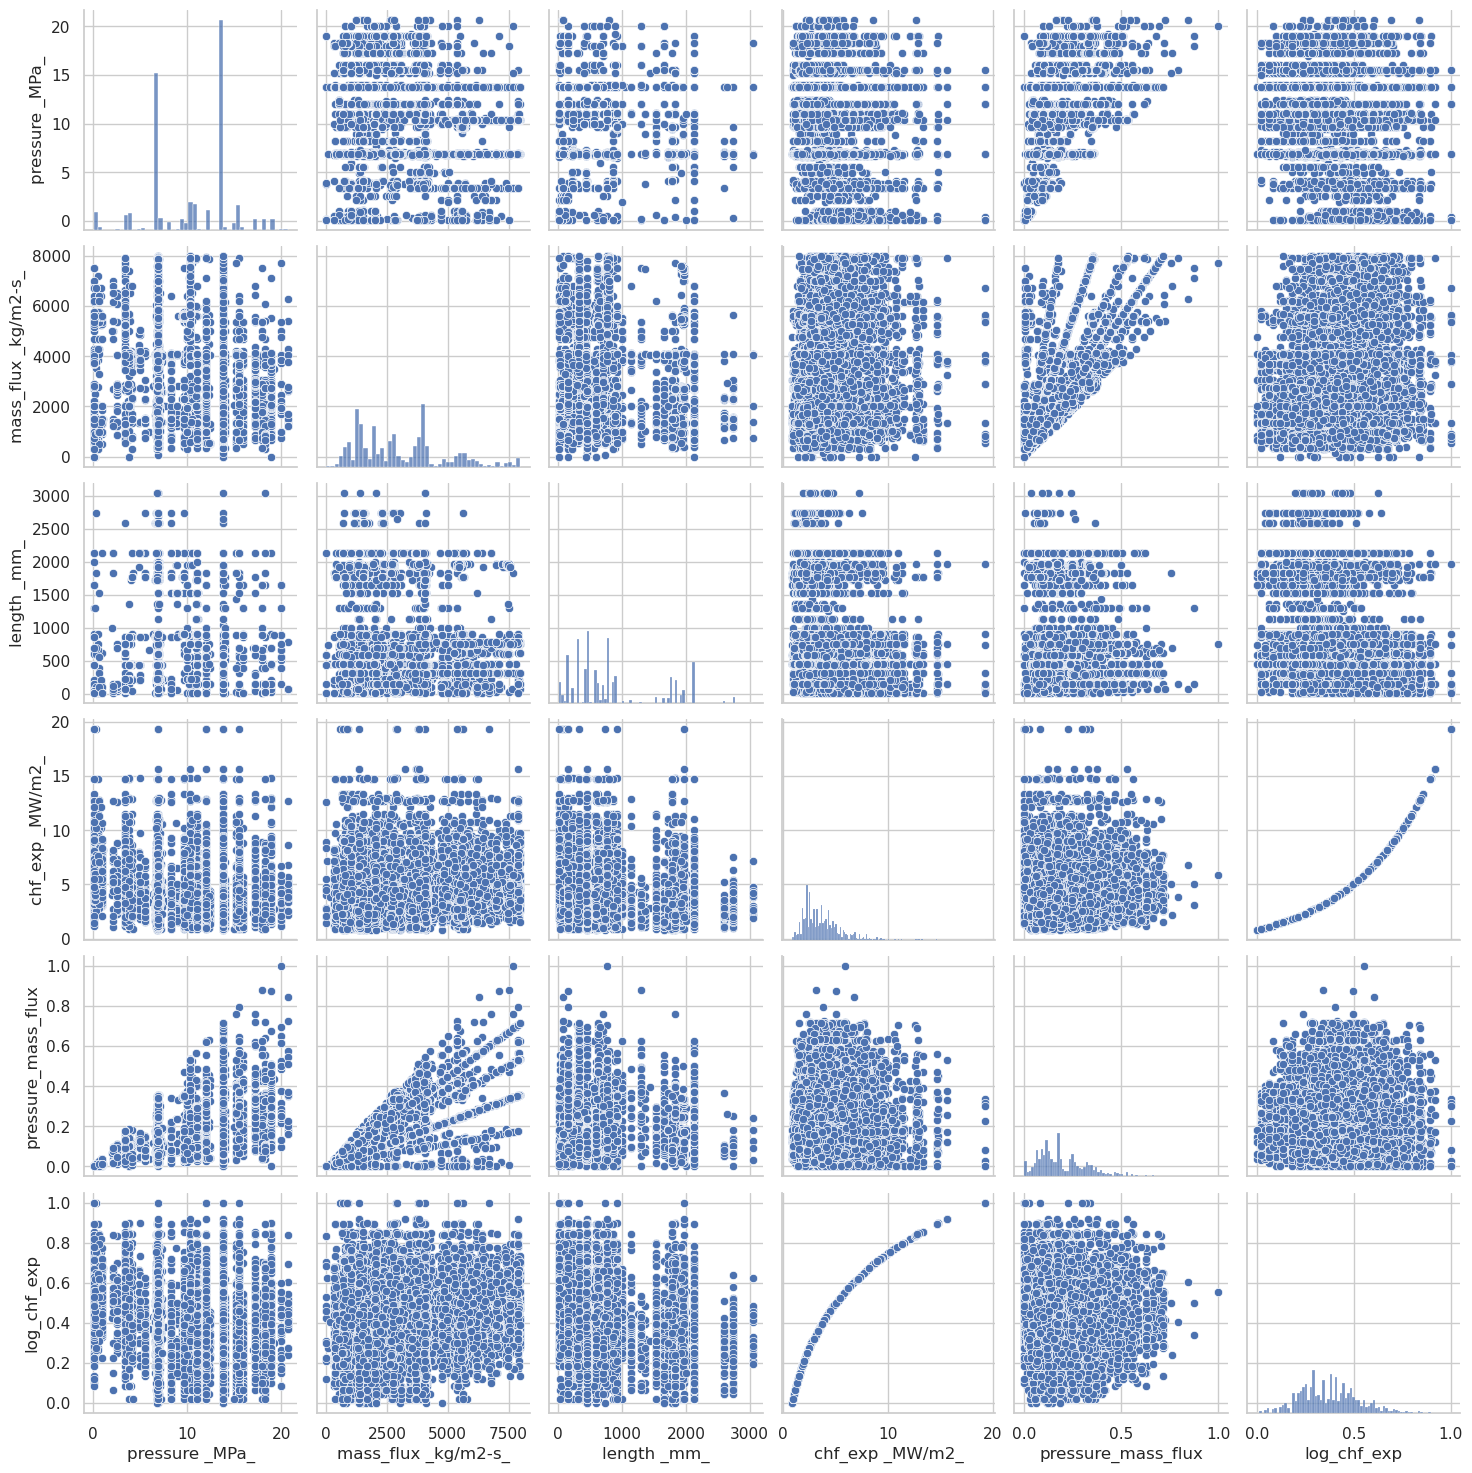

In [30]:
# Visualize relationships between numerical features
sns.pairplot(preprocessed_data[numerical_columns])
plt.show()


`sns.pairplot`: This code snippet creates a pairwise scatter plot of numerical features using seaborn's pairplot function. It shows the relationships between different numerical features.

In [31]:
# Visualize relationships between categorical features
categorical_columns = ['author_1', 'author_2', 'author_3', 'author_4', 'author_5', 'author_6',
                       'author_7', 'author_8', 'author_9', 'author_10', 'geometry_1',
                       'geometry_2', 'geometry_3']

`categorical_columns`: This is a list of column names that represent categorical features.

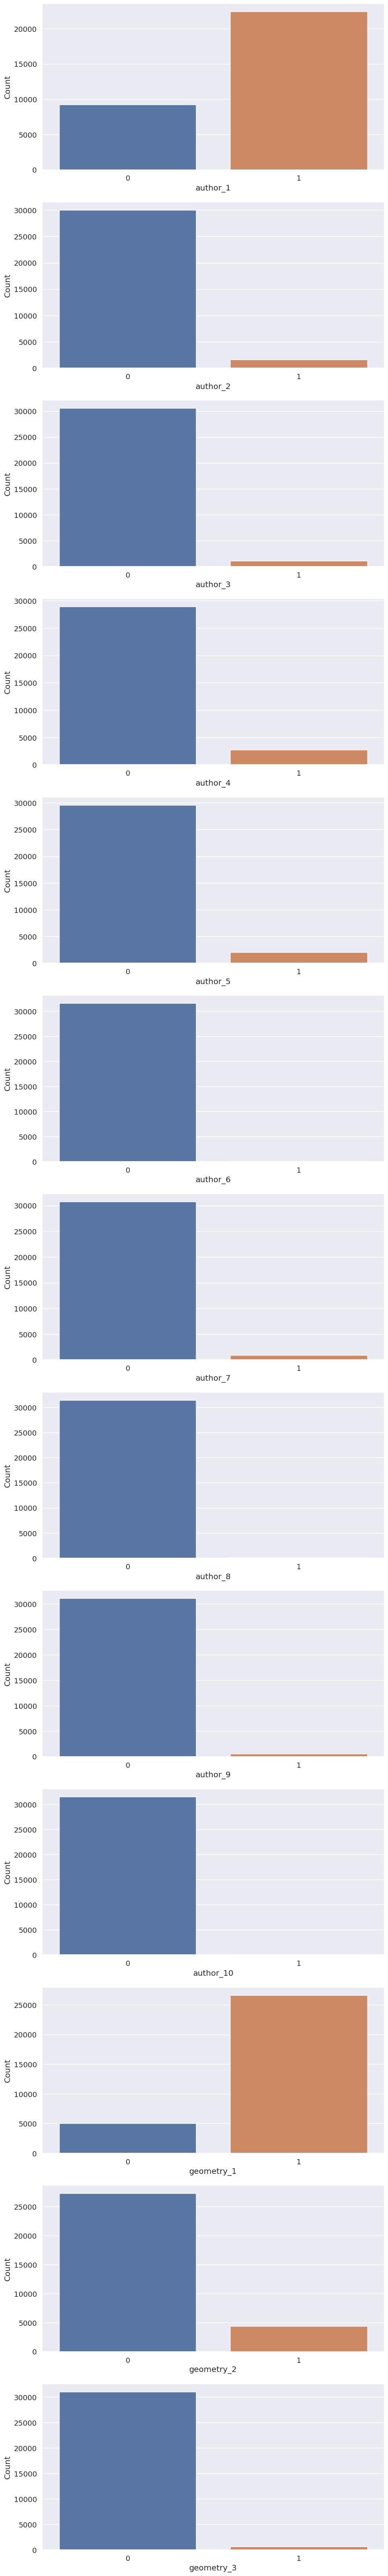

In [32]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 5 * len(categorical_columns)))
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(x=col, data=preprocessed_data, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

`sns.countplot`: This code snippet creates a count plot for each categorical feature using seaborn's countplot function. It displays the count of occurrences for each category in the feature.

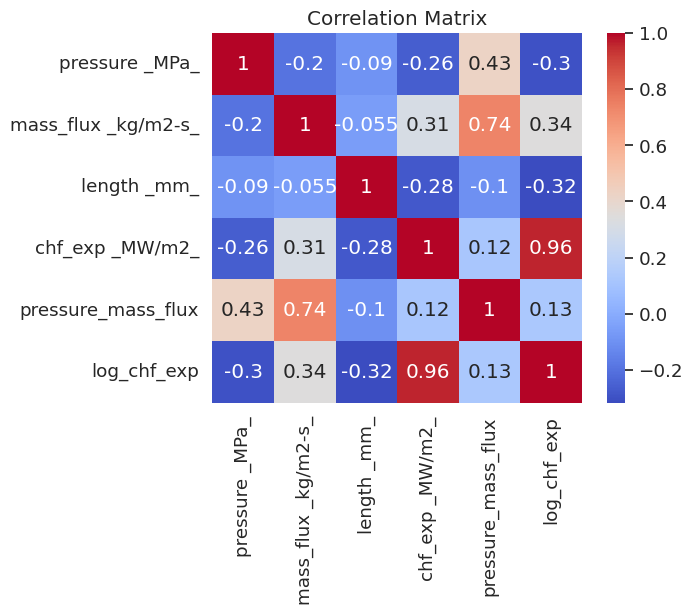

In [33]:
# Visualize correlations between features
correlation_matrix = preprocessed_data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

`correlation_matrix`: This code snippet calculates the correlation matrix between numerical features. It represents the correlation between each pair of numerical features.

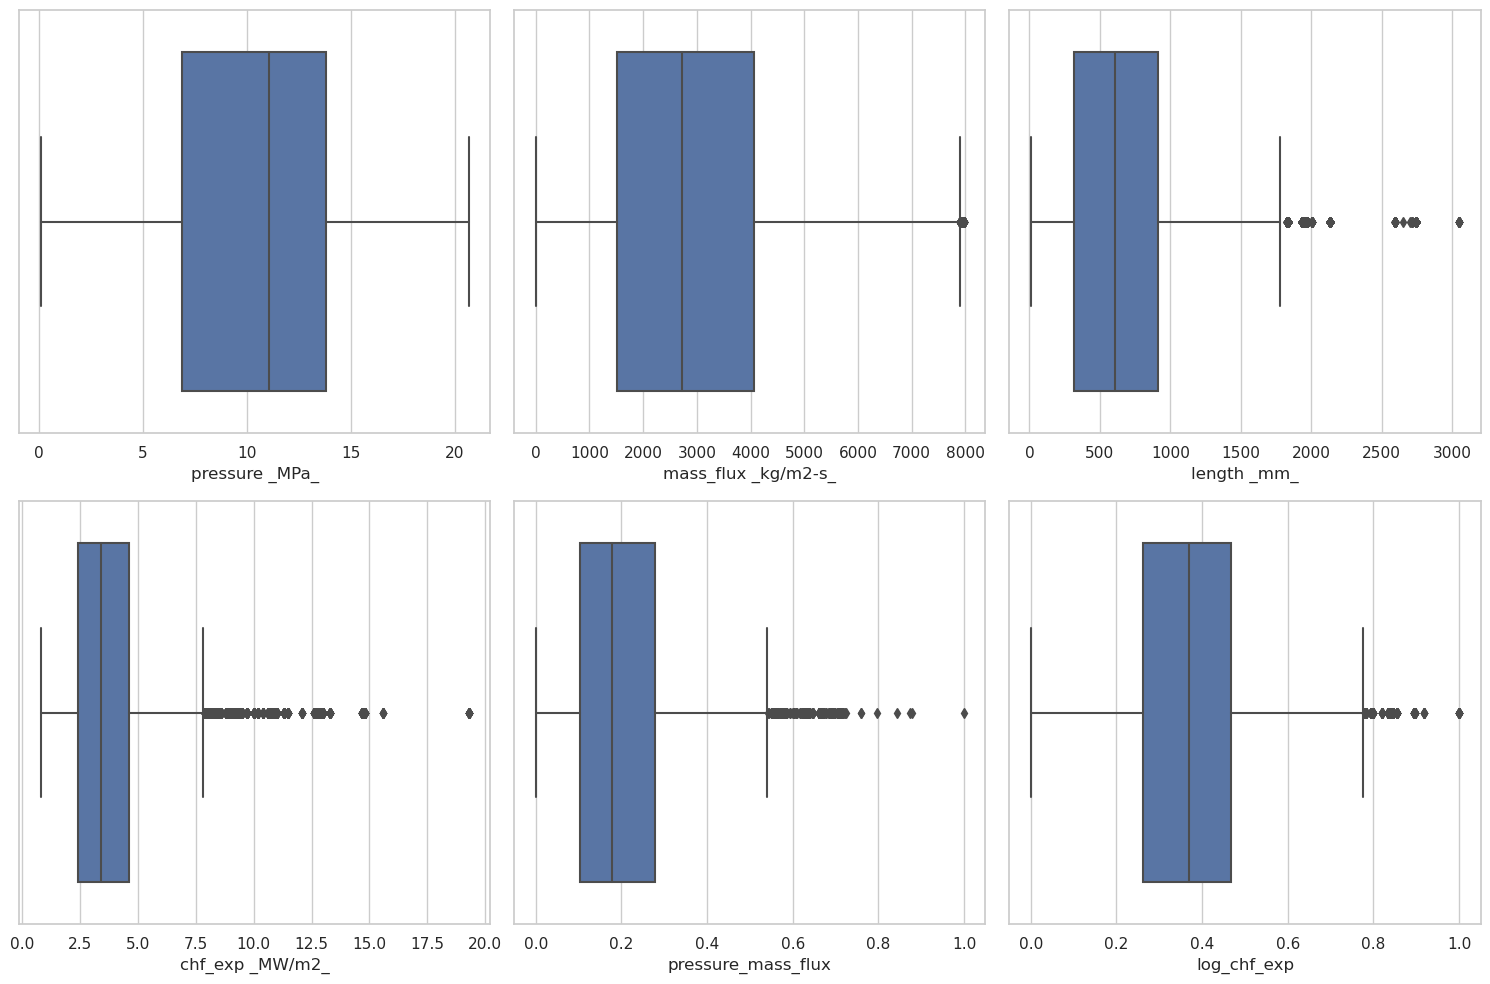

In [34]:
# Box plots of numerical features
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=col, data=preprocessed_data, ax=ax)
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()


`sns.boxplot`: This code snippet creates a box plot for each numerical feature using seaborn's boxplot function. It displays the distribution of each feature, including median, quartiles, and outliers.

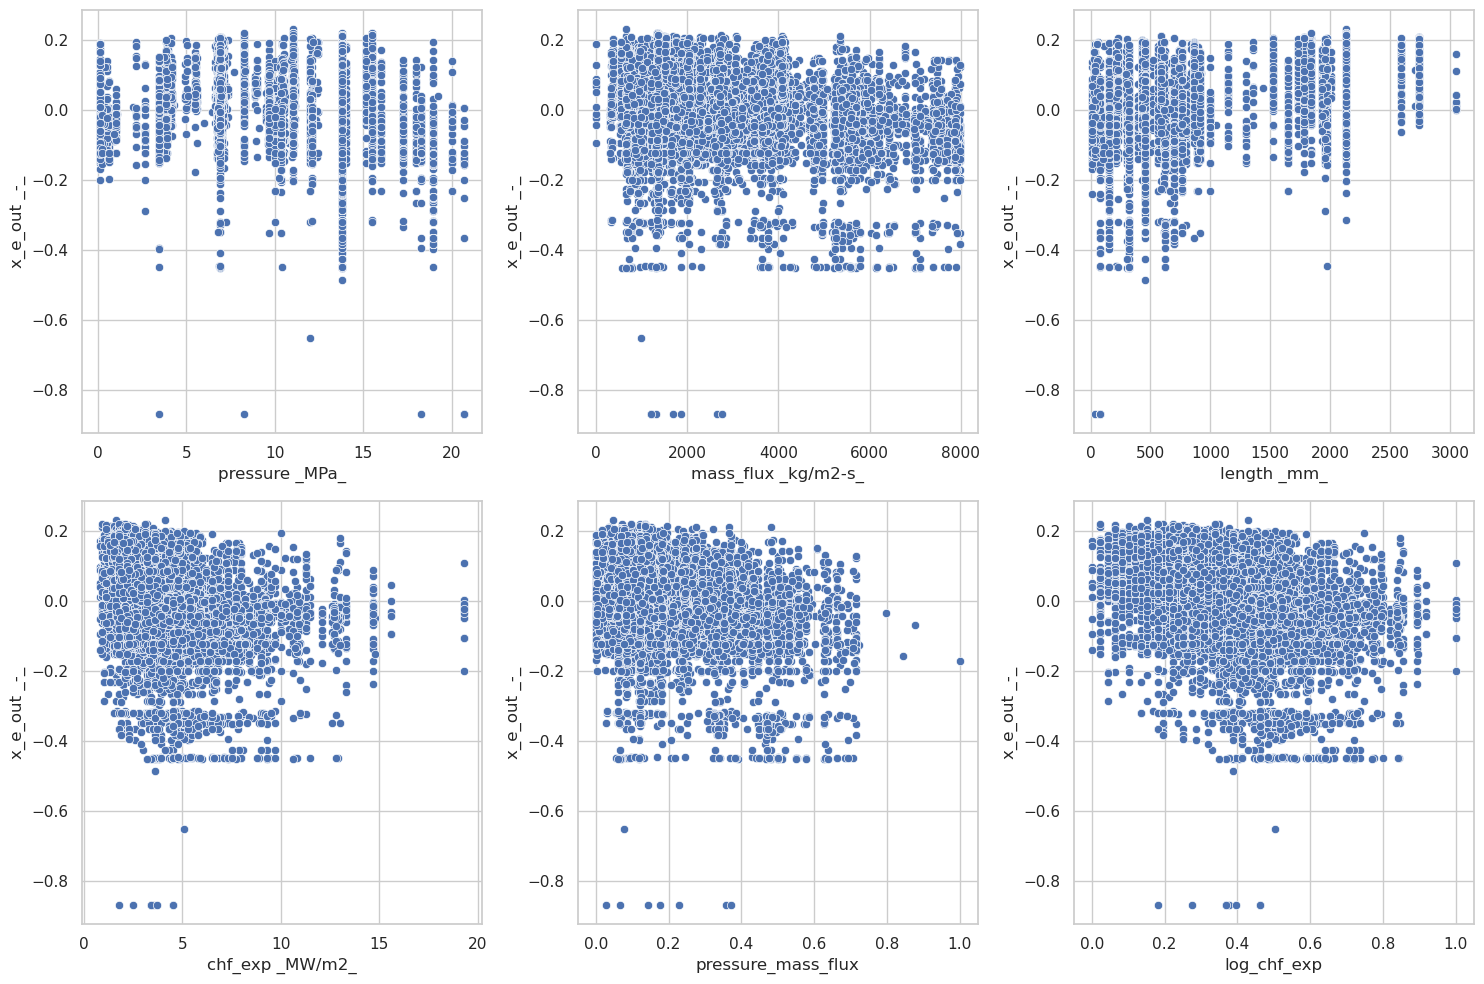

In [38]:
# Scatter plots of numerical features against target variable
target_variable = 'x_e_out _-_'  
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    ax = axes[i // 3, i % 3]
    sns.scatterplot(x=col, y=target_variable, data=preprocessed_data, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel(target_variable)
plt.tight_layout()
plt.show()

`sns.scatterplot`: This code snippet creates scatter plots of numerical features against the target variable using seaborn's scatterplot function. It helps to understand the relationship between each numerical feature and the target variable.

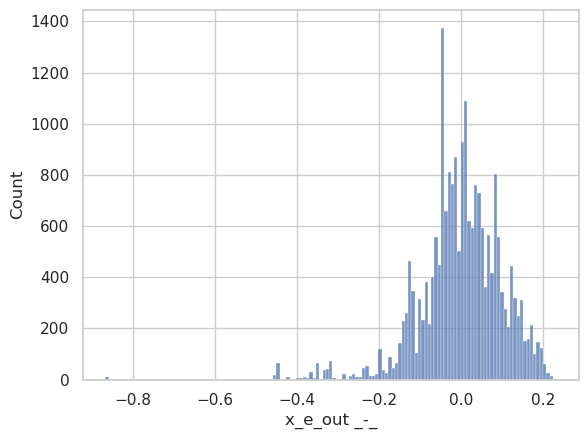

In [39]:
# Bar plot of the target variable
sns.histplot(preprocessed_data[target_variable])
plt.xlabel(target_variable)
plt.ylabel('Count')
plt.show()


`sns.histplot`: This code snippet creates a histogram of the target variable using seaborn's histplot function. It visualizes the distribution of the target variable.

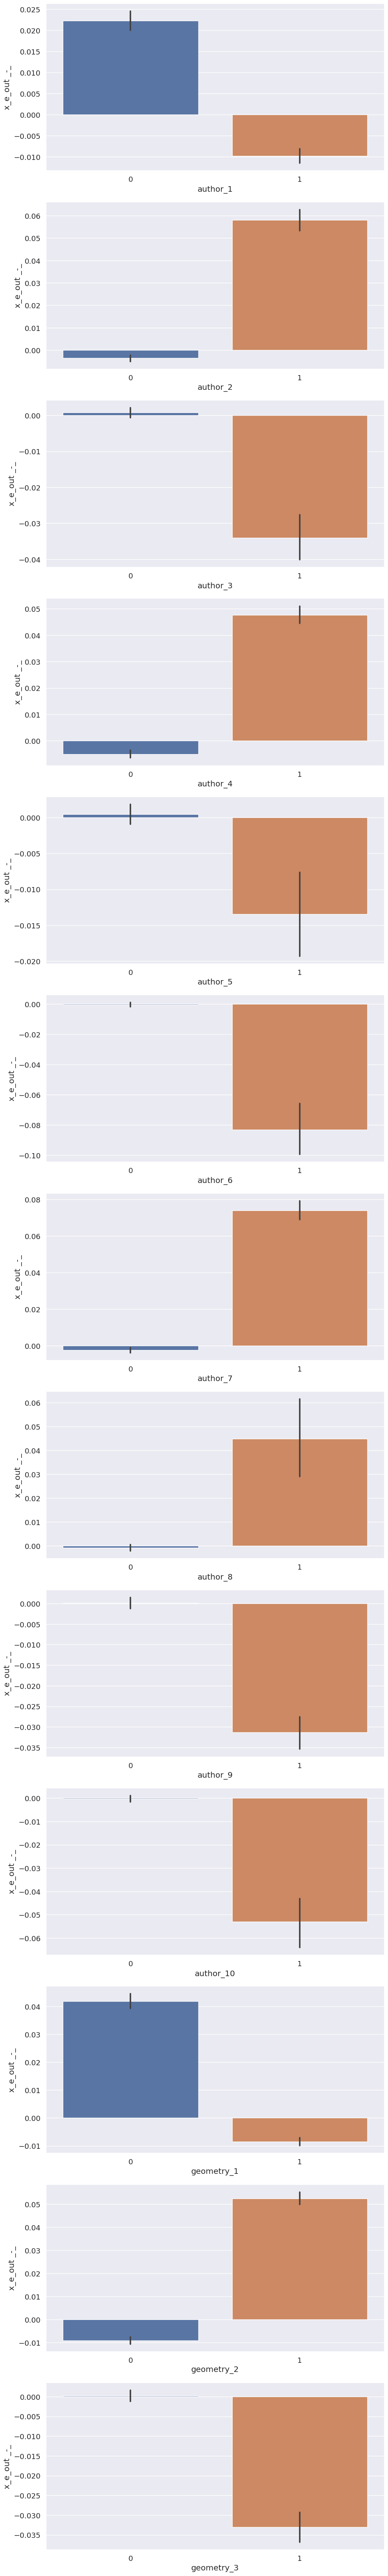

In [40]:
# Bar plot of the interaction between categorical features and target variable
sns.set(font_scale=1.2)
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 5 * len(categorical_columns)))
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    sns.barplot(x=col, y=target_variable, data=preprocessed_data, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel(target_variable)
plt.tight_layout()
plt.show()

`sns.barplot`: This code snippet creates a bar plot for the interaction between each categorical feature and the target variable using seaborn's barplot function. It shows the average value of the target variable for each category in the categorical feature.

## 4. Model Selection

In [41]:
# Define imputation strategies
mean_imputer = SimpleImputer(strategy='mean')
knn_imputer = KNNImputer(n_neighbors=3)
iterative_imputer = IterativeImputer(max_iter=5400, random_state=0)


In [42]:
models = [
    ('et', GridSearchCV(ExtraTreesRegressor(random_state=0),
                        param_grid={'n_estimators': [100, 200, 300],
                                    'max_depth': [None, 5, 10],
                                    'min_samples_split': [2, 5, 10]},
                        cv=3,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=2)),
    ('rf', GridSearchCV(RandomForestRegressor(random_state=0),
                        param_grid={'n_estimators': [100, 200, 300],
                                    'max_depth': [None, 5, 10],
                                    'min_samples_split': [2, 5, 10]},
                        cv=3,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=2)),
    ('gbr', GridSearchCV(GradientBoostingRegressor(random_state=0),
                         param_grid={'n_estimators': [100, 200, 300],
                                     'max_depth': [3, 5, 7],
                                     'learning_rate': [0.01, 0.1, 0.2]},
                         cv=3,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         verbose=2)),
    ('xgb', GridSearchCV(XGBRegressor(random_state=0),
                         param_grid={'n_estimators': [100, 200, 300],
                                     'max_depth': [3, 5, 7],
                                     'learning_rate': [0.01, 0.1, 0.2]},
                         cv=3,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         verbose=2)),
    ('lgbm', GridSearchCV(LGBMRegressor(random_state=0),
                          param_grid={'n_estimators': [100, 200, 300],
                                      'max_depth': [None, 5, 10],
                                      'learning_rate': [0.01, 0.1, 0.2]},
                          cv=3,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          verbose=2)),
    ('catboost', GridSearchCV(CatBoostRegressor(random_state=0, verbose=0),
                              param_grid={'n_estimators': [100, 200, 300],
                                          'max_depth': [3, 5, 7],
                                          'learning_rate': [0.01, 0.1, 0.2]},
                              cv=3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              verbose=2))
]

In [43]:
# Create an ensemble using voting
ensemble = VotingRegressor(estimators=models)


In [44]:
# Feature imputation pipeline
feature_imputation_pipeline = Pipeline([
    ('imputer', iterative_imputer),
    ('model', ensemble)
])


In [45]:
# Prepare the training and testing datasets
X_train = preprocessed_data.drop('x_e_out _-_', axis=1)
y_train = preprocessed_data['x_e_out _-_']
X_test = preprocessed_data[preprocessed_data['x_e_out _-_'].isnull()]
X_test = X_test.drop('x_e_out _-_', axis=1)


In [46]:
# Check and impute missing values in the target variable
if y_train.isnull().sum() > 0:
    y_train = y_train.fillna(y_train.mean())


In [47]:
# Fit the imputation pipeline on the training data
feature_imputation_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  11.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  11.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  21.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  22.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  22.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=  33.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=  33.2s
[CV] END max_depth=None, m

Pipeline(steps=[('imputer', IterativeImputer(max_iter=5400, random_state=0)),
                ('model',
                 VotingRegressor(estimators=[('et',
                                              GridSearchCV(cv=3,
                                                           estimator=ExtraTreesRegressor(random_state=0),
                                                           n_jobs=-1,
                                                           param_grid={'max_depth': [None,
                                                                                     5,
                                                                                     10],
                                                                       'min_samples_split': [2,
                                                                                             5,
                                                                                             10],
                                                                       'n_estimators': [100,
                                                                                        200,
                                                                                        300]},
                                                           scoring='neg_mean_squared_error',
                                                           verbose=2)),
                                             ('rf',
                                              GridSearchCV...
                                                                                         0.2],
                                                                       'max_depth': [None,
                                                                                     5,
                                                                                     10],
                                                                       'n_estimators': [100,
                                                                                        200,
                                                                                        300]},
                                                           scoring='neg_mean_squared_error',
                                                           verbose=2)),
                                             ('catboost',
                                              GridSearchCV(cv=3,
                                                           estimator=<catboost.core.CatBoostRegressor object at 0x7e9592733040>,
                                                           n_jobs=-1,
                                                           param_grid={'learning_rate': [0.01,
                                                                                         0.1,
                                                                                         0.2],
                                                                       'max_depth': [3,
                                                                                     5,
                                                                                     7],
                                                                       'n_estimators': [100,
                                                                                        200,
                                                                                        300]},
                                                           scoring='neg_mean_squared_error',
                                                           verbose=2))]))])

Following steps were performed in the above model selection stage

- We define imputation strategies like `mean_imputer`, `knn_imputer`, and `iterative_imputer` for handling missing values.

- The models are defined as a list of tuples, where each tuple contains a model name and its corresponding `GridSearchCV` object with the specified parameter grid, cross-validation settings, and scoring metric.

- We create an ensemble using the `VotingRegressor` class and pass the list of models to it.

- The feature imputation pipeline is created using `sklearn.pipeline.Pipeline`. It includes the imputer and the ensemble model.

- We prepare the training and testing datasets by separating the features (`X_train` and `X_test`) and the target variable (`y_train`).

- If there are missing values in the target variable, we fill them with the mean value.

- Finally, we fit the imputation pipeline on the training data.


## 5. Generating submission

In [49]:
# Impute missing values in the test data
X_test_imputed = feature_imputation_pipeline['imputer'].transform(X_test)

It uses the feature imputation pipeline to impute missing values in the test data (`X_test`). It accesses the imputer component of the pipeline (`feature_imputation_pipeline['imputer']`) and applies the `transform` method to impute the missing values in `X_test`. The imputed data is then stored in the `X_test_imputed` variable.


In [50]:
# Generate predictions on the imputed test data
predictions = feature_imputation_pipeline.predict(X_test_imputed)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IterativeImputer was fitted with feature names
  warnings.warn(



After imputing the missing values in the test data, this line generates predictions on the imputed test data. It uses the `predict` method of the feature imputation pipeline (`feature_imputation_pipeline.predict`) and passes the imputed test data (`X_test_imputed`) as input. The predicted values are stored in the `predictions` variable.


In [51]:
# Create a submission dataframe
submission_df = pd.DataFrame({'id': X_test.index, 'x_e_out [-]': predictions})


It creates a submission dataframe (`submission_df`) using the predicted values. It uses the `pd.DataFrame` constructor to create a DataFrame object. The DataFrame is constructed with a dictionary where the keys represent the column names (`'id'` and `'x_e_out [-]'`) and the values are the respective data (`X_test.index` and `predictions`). The `'id'` column contains the index values from `X_test` and the `'x_e_out [-]'` column contains the predicted values.


In [52]:
# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)


This line of code saves the submission dataframe (`submission_df`) to a CSV file named `'submission.csv'`.


In [53]:
submission_df

,id,x_e_out [-]
0,4,0.006912
1,7,-0.062240
2,10,-0.031519
3,12,-0.008703
4,23,0.029425
...,...,...
10410,31633,0.047585
10411,31634,-0.030575
10412,31637,0.012339
10413,31640,-0.034133


Viewing the contents of the submission dataframe

## 6. Feature Importance

In [56]:
importance_scores = []

# Iterate over each model in the ensemble
for name, model in ensemble.named_estimators_.items():
    if hasattr(model, 'best_estimator_'):
        # If the model is a GridSearchCV, get the best estimator
        best_model = model.best_estimator_
    else:
        best_model = model
    
    # Check if the best_model has feature_importances_ attribute
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        importance_scores.append({'Model': name, 'Feature': X_train.columns, 'Importance': feature_importances})


The code snippet aims to calculate the feature importances for each model in the ensemble and store the results in the `importance_scores` list.

It's functionality can be broken down into the following steps.

1. Initialize an empty list `importance_scores` to store the feature importances for each model.

2. Iterate over each model in the ensemble using the `ensemble.named_estimators_.items()` method. 

3. Check if the current model is a `GridSearchCV` object by using the `hasattr()` function to see if it has the `best_estimator_` attribute. If it does, assign the best estimator to the `best_model` variable; otherwise, assign the current model itself.

4. Check if the `best_model` has the `feature_importances_` attribute. This is typically available for tree-based models such as RandomForestRegressor, ExtraTreesRegressor, etc., but not for all models.

5. If the `best_model` has the `feature_importances_` attribute, retrieve the feature importances using `best_model.feature_importances_`.

6. Create a dictionary containing the model name, feature names (`X_train.columns`), and the corresponding feature importances. Append this dictionary to the `importance_scores` list.


In [61]:
# Combine the importance scores into a DataFrame
importance_scores = pd.DataFrame(importance_scores)



The snippet combines the importance scores, which were previously stored as a list of dictionaries, into a pandas DataFrame for better analysis

In [62]:
importance_data = []

for model, features, importances in zip(importance_scores['Model'], importance_scores['Feature'], importance_scores['Importance']):
    for feature, importance in zip(features, importances):
        importance_data.append({'Model': model, 'Feature': feature, 'Importance': importance})

flattened_importance_scores = pd.DataFrame(importance_data)

The snippet flattens the `importance_scores` DataFrame into a new DataFrame called `flattened_importance_scores`. It reorganizes the data into a flat structure where each row represents a specific model, feature, and its corresponding importance score.

The steps in the code are as follows - 

1. An empty list `importance_data` is initialized to store the flattened importance data.

2. The `zip()` function is used to iterate simultaneously over the 'Model', 'Feature', and 'Importance' columns of the `importance_scores` DataFrame.

3. For each iteration, another `zip()` function is used to iterate over the lists of features and importances for the current model.

4. Inside the nested loop, a dictionary is created for each feature and its importance, along with the corresponding model name.

5. The dictionary is appended to the `importance_data` list.

6. Finally, the `importance_data` list is used to create a new DataFrame called `flattened_importance_scores` using the `pd.DataFrame()` function.

The resulting `flattened_importance_scores` DataFrame will have three columns: 'Model', 'Feature', and 'Importance'. Each row represents a specific feature's importance score for a particular model.

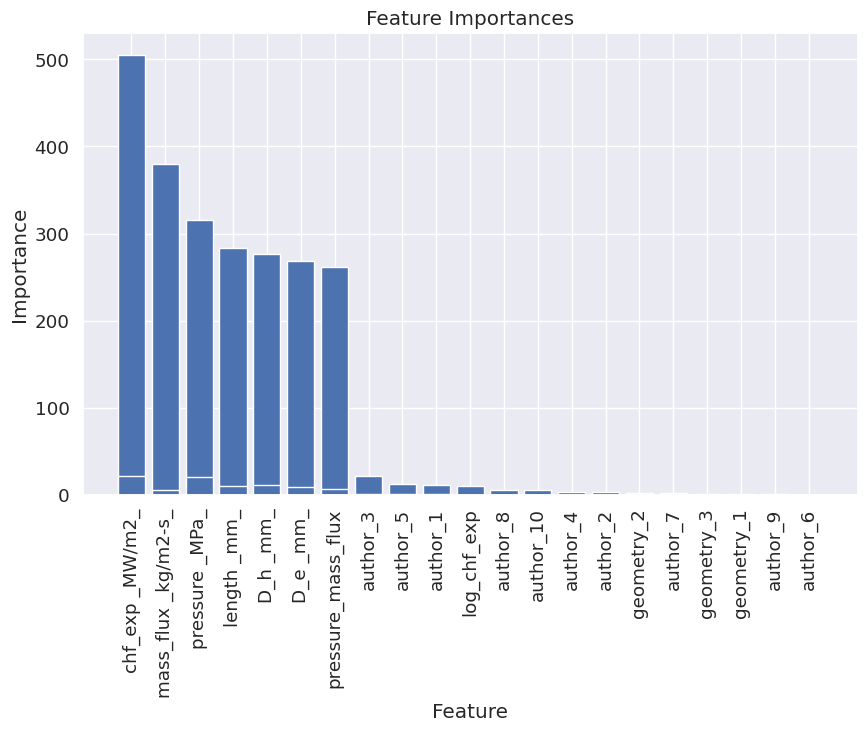

In [65]:
# Sort the feature importances
sorted_importances = flattened_importance_scores.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(sorted_importances['Feature'], sorted_importances['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

The code snippet above sorts the `flattened_importance_scores` DataFrame in descending order based on the 'Importance' column and then plots the feature importances using a bar chart.

The steps in the code are as follows - 

- `sorted_importances = flattened_importance_scores.sort_values(by='Importance', ascending=False)`: Sorts the `flattened_importance_scores` DataFrame in descending order based on the 'Importance' column and assigns the sorted DataFrame to the variable `sorted_importances`.

   - `plt.figure(figsize=(10, 6))`: Creates a new figure with a specified size.
   
   - `plt.bar(sorted_importances['Feature'], sorted_importances['Importance'])`: Creates a bar chart with the sorted feature importances. The 'Feature' column is used as the x-axis values, and the 'Importance' column is used as the height of the bars.
   
   - `plt.xlabel('Feature')`: Sets the label for the x-axis as 'Feature'.
   
   - `plt.ylabel('Importance')`: Sets the label for the y-axis as 'Importance'.
   
   - `plt.title('Feature Importances')`: Sets the title of the plot as 'Feature Importances'.
   - `plt.xticks(rotation=90)`: Rotates the x-axis tick labels by 90 degrees to improve readability if there are many features.
   
   - `plt.show()`: Displays the plot.

The resulting plot will show the feature importances in a bar chart, with the features sorted in descending order based on their importance scores.

## 7. Model Interpretation

In [67]:
import shap

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

SHAP (SHapley Additive exPlanations) is a unified measure of feature importance that provides a more nuanced understanding of the contributions of each feature to model predictions. It assigns a value to each feature in a prediction, indicating its impact on the prediction compared to the average prediction.


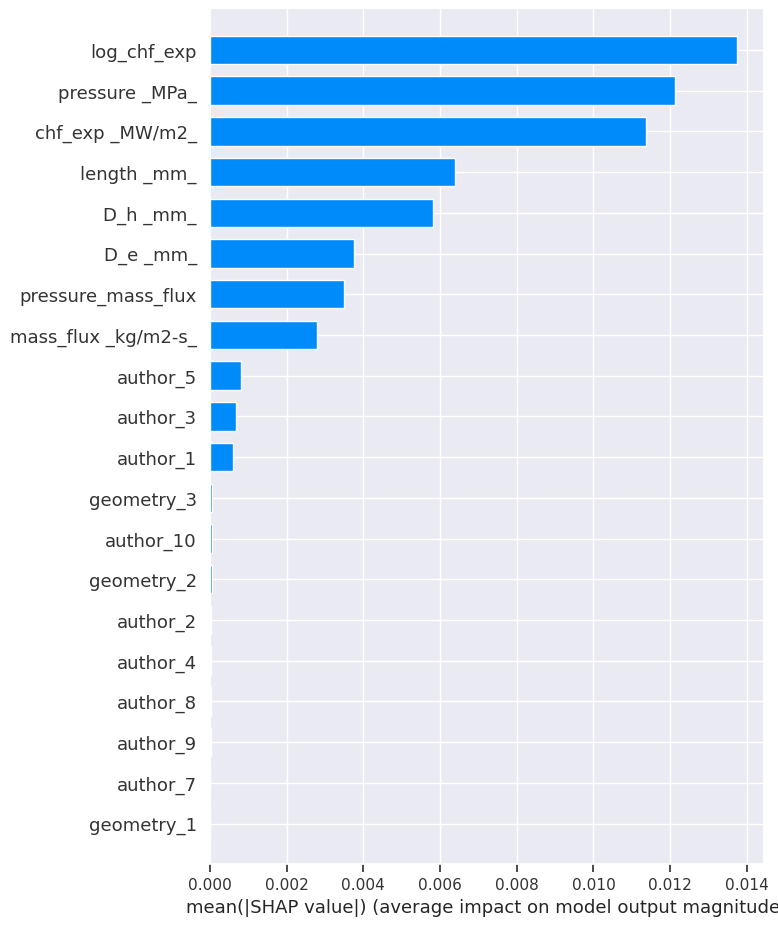

In [75]:

# Extract the best estimator from the grid search object
best_gbr = ensemble.named_estimators_['gbr'].best_estimator_

# Create an explainer object
explainer = shap.Explainer(best_gbr)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_imputed)

# Retrieve the feature names from your original dataset or trained model
feature_names = X_train.columns


# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_imputed, feature_names=feature_names, plot_type="bar")

In the code, the steps for using the SHAP library for model interpretation are as follows:

1. **Extract the best estimator**: The best estimator is extracted using the `best_estimator_` attribute.

2. **Create an explainer object**: Create an explainer object using the `Explainer` class from the SHAP library. Pass the best estimator (`best_gbr`) as the input to the explainer object.

3. **Calculate SHAP values**: Use the explainer object to calculate the SHAP values for the test data (`X_test_imputed`). The `shap_values` method of the explainer object is called, and the SHAP values are assigned to the variable `shap_values`.

4. **Plot the SHAP summary plot**: Visualize the SHAP values using the `summary_plot` function from the SHAP library. Pass the SHAP values (`shap_values`), the test data (`X_test_imputed`), and specify the `plot_type` as "bar" to generate a summary plot with bar charts representing the feature importance.

